<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# A ver si nos hacemos ricos (LSTM edition)<a id="top"></a>

<i>Última actualización: 2024-03-07</small></i></div>

***

## Introducción

El intento anterior de predecir el mercado de valores no salió como esperábamos. Vamos a intentarlo de nuevo, esta vez con unas redes LSTM completamente nuevas, y utilizando únicamente el valor bursátil anterior.

## Objetivos

Crearemos un modelo de regresión para predecir un valor de bolsa dado el valor anterior. Al final habremos aprendido a:

- Predecir la tendencia de una serie temporal utilizando LSTM.
- Pensar dos veces antes de invertir en bolsa en base a las recomendaciones realizadas por los modelos que hemos programado.

## Bibliotecas y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del cuaderno.

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

2023-05-18 19:30:48.243703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 19:30:48.657161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 19:30:48.657184: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-18 19:30:50.640003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Carga y preparación de datos

Recargaremos los datos del historial de Google como hicimos en el anterior intento de predicción bursátil.

In [3]:
CODE = 'GOOG'
BASE_URL = f'https://query1.finance.yahoo.com/v7/finance/download/{CODE}'
# Interval
today = datetime.datetime.now()
five_years_ago = today - datetime.timedelta(days=365*5)
# Timestamps (as integer) for the interval
period2 = int(today.timestamp())
period1 = int(five_years_ago.timestamp())
# Now get the dataframe
df = pd.read_csv(
    f'{BASE_URL}?period1={period1}&period2={period2}&interval=1d',
    index_col='Date',
    parse_dates=['Date'],
    dtype=np.float32
)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-21,53.702999,54.400002,53.682499,53.979000,53.979000,20464000.0
2018-05-22,54.178001,54.329498,53.334499,53.486500,53.486500,21800000.0
2018-05-23,53.256500,54.039001,53.085499,53.984501,53.984501,21214000.0
2018-05-24,53.950001,54.023499,53.307499,53.962002,53.962002,15336000.0
2018-05-25,53.951000,54.127998,53.688751,53.783001,53.783001,17988000.0


Vamos a omitir el resto de valores y a centrarnos únicamente en la evolución temporal del valor de cierre de la acción. Eso sí, en lugar de utilizar el valor absoluto, lo que utilizaremos será la variación del valor respecto al día anterior. No vamos a hacer ninguna transformación más allá de normalizar y poco más, por lo que podemos convertirlo a un array de numpy sin problemas.

In [4]:
dataset = df[['Close']].diff(axis=0).values[1:]
dataset

array([[-0.4925003 ],
       [ 0.4980011 ],
       [-0.02249908],
       ...,
       [ 3.1299973 ],
       [ 1.390007  ],
       [ 2.0299988 ]], dtype=float32)

Ahora crearemos un `MinMaxScaler` para hacer la normalización y desnormalización de nuestros datos. Aprovechamos y los dejamos ya normalizados.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)
dataset

Ya tenemos nuestro conjunto de datos casi listo para trabajar. Hemos transformado todo el conjunto de datos para hacer el ejercicio más corto, pero recuerde que en la normalización de los datos no deben entrar los datos de prueba El siguiente paso es especificar la longitud de la secuencia, que es lo mismo que el número de pasos temporales o el número de observaciones previas a considerar para hacer una predicción.

Utilizaremos un tamaño de 20, lo que significa que para predecir el valor de un día se utilizarán los 20 anteriores (aproximadamente un mes). Para ello crearemos los conjuntos `X_train` y `Y_train`, dos arrays NumPy que contendrán las secuencias y el siguiente valor de esa secuencia respectivamente.

In [6]:
SEQUENCE_LEN = 10

x_train = []
y_train = []
for i in range(len(dataset) - SEQUENCE_LEN - 9):
    x_train.append(dataset[i:i + SEQUENCE_LEN, 0])
    y_train.append(dataset[i + SEQUENCE_LEN + 9, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

for i in range(10):
    print(f'... {x_train[i][-3:]} -> {y_train[i]}')
print('-'*72)
print(f'x_train shape: {x_train.shape}, Y_train shape: {y_train.shape}')

... [1.7254982  0.98950195 0.01850128] -> -0.2700004577636719
... [ 0.98950195  0.01850128 -0.13899994] -> 0.08900070190429688
... [ 0.01850128 -0.13899994 -0.651001  ] -> -0.6090011596679688
... [-0.13899994 -0.651001   -0.1495018 ] -> -0.10900115966796875
... [-0.651001   -0.1495018   0.45600128] -> -1.5334968566894531
... [-0.1495018   0.45600128  0.46649933] -> -0.3175010681152344
... [ 0.45600128  0.46649933 -0.22650146] -> -0.7239990234375
... [ 0.46649933 -0.22650146  0.86650085] -> 0.5119972229003906
... [-0.22650146  0.86650085  0.00699997] -> 0.071502685546875
... [0.86650085 0.00699997 1.0600014 ] -> 0.5904998779296875
------------------------------------------------------------------------
x_train shape: (1238, 10), Y_train shape: (1238,)


Recordemos que los datos de entrada de una red recurrente deben tener una dimensión específica, por lo que ahora los transformaremos para adaptarlos a este requisito.

In [7]:
x_train = np.reshape(x_train, (*x_train.shape[:2], 1))

print(f'X_train shape: {x_train.shape}')

X_train shape: (1238, 10, 1)


Por último, ahora que tenemos los datos listos, extraigamos los últimos valores (por ejemplo, 100) para que sirvan como conjunto de prueba

In [8]:
TEST_SIZE = 250

x_train, x_test = x_train[:-TEST_SIZE], x_train[-TEST_SIZE:]
y_train, y_test = y_train[:-TEST_SIZE], y_train[-TEST_SIZE:]

print(f'X_train shape: {x_train.shape}, Y_train shape: {y_train.shape}')
print(f'X_test shape: {x_test.shape}, Y_test shape: {y_test.shape}')

X_train shape: (988, 10, 1), Y_train shape: (988,)
X_test shape: (250, 10, 1), Y_test shape: (250,)


## Implementación y entrenamiento del modelo

Pasamos a construir nuestra red neuronal recurrente. Crearemos una estructura apilada de 3 nodos `LSTM` de 40 nodos cada uno, con una capa `Dropout` después de cada capa. A continuación, utilizaremos como optimizador _Adam_ y como medida de pérdida el error cuadrático medio.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2023-05-18 19:30:54.074078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-18 19:30:54.074134: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-18 19:30:54.074162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bulma): /proc/driver/nvidia/version does not exist
2023-05-18 19:30:54.074618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

Ahora, entrenaremos el modelo durante... digamos 100 épocas, con los datos de entrenamiento que hemos preparado.

In [10]:
history = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
31/31 [==============================] - 10s 47ms/step - loss: 2.7262
Epoch 2/100
31/31 [==============================] - 1s 47ms/step - loss: 2.7175
Epoch 3/100
31/31 [==============================] - 2s 54ms/step - loss: 2.7158
Epoch 4/100
31/31 [==============================] - 2s 51ms/step - loss: 2.7146
Epoch 5/100
31/31 [==============================] - 1s 45ms/step - loss: 2.7150
Epoch 6/100
31/31 [==============================] - 2s 66ms/step - loss: 2.7170
Epoch 7/100
31/31 [==============================] - 2s 60ms/step - loss: 2.7149
Epoch 8/100
31/31 [==============================] - 2s 56ms/step - loss: 2.7141
Epoch 9/100
31/31 [==============================] - 2s 51ms/step - loss: 2.7147
Epoch 10/100
31/31 [==============================] - 1s 48ms/step - loss: 2.7149
Epoch 11/100
31/31 [==============================] - 2s 50ms/step - loss: 2.7160
Epoch 12/100
31/31 [==============================] - 1s 41ms/step - loss: 2.7151
Epoch 13/100
31/31 [====

Echemos un vistazo a la evolución del entrenamiento.

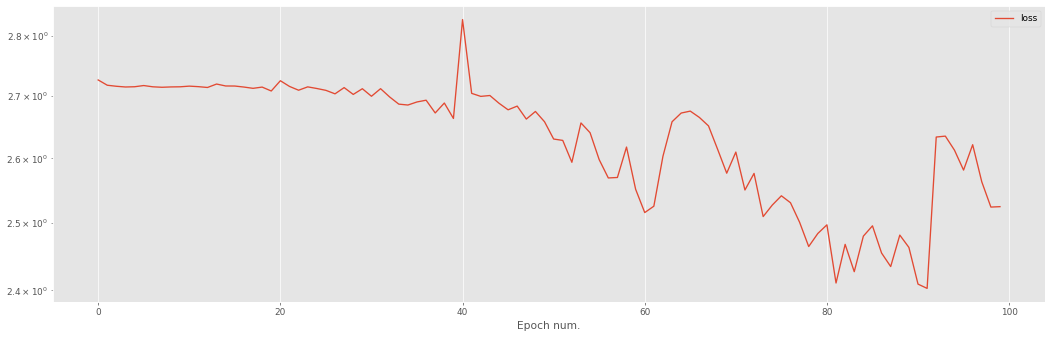

In [11]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

## Evaluación del modelo

Una vez hecho todo, éste es el paso fácil. Tenemos que pasar nuestras fechas de prueba para ver cómo se comporta nuestro modelo con valores que nunca ha visto. Los compararemos con los valores reales para ver lo bien que lo hace.

8/8 [==============================] - 1s 8ms/step


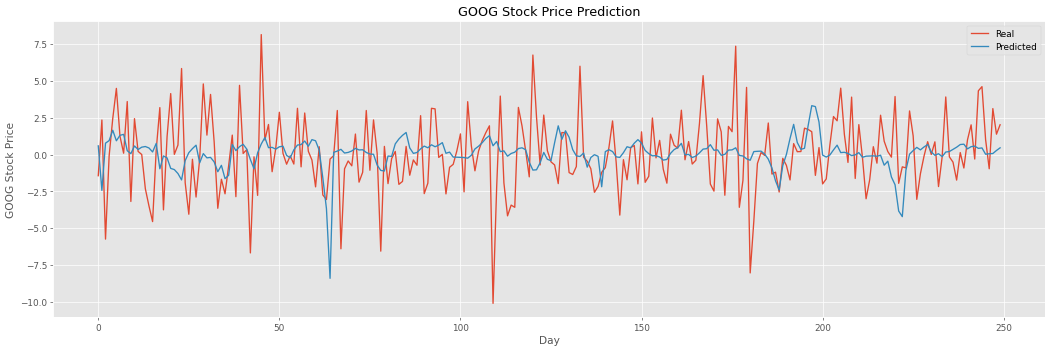

In [12]:
predicted = model.predict(x_test)
#predicted = scaler.inverse_transform(predicted)
#real = scaler.inverse_transform(y_test.reshape((-1, 1)))
real = y_test.reshape((-1, 1))

plt.plot(real, label = 'Real')
plt.plot(predicted, label = 'Predicted')
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show()

Al menos no es un comportamiento como el anterior. Pero sigue siendo inútil. Aparentemente no vamos a hacernos ricos, al menos no así.

## Conclusiones

En este _notebook_ hemos aprendido que es muy fácil cambiar entre tipos de unidades recurrentes. La API de Keras nos permite sustituir uno y otro prácticamente sin esfuerzo.

También hemos visto que no todos los problemas de series temporales son resolubles, al menos no con los datos que tenemos a mano en un principio. Por supuesto que el valor bursátil de una acción es una serie temporal, pero hay muchas variables relacionadas con los valores, muchas de ellas emocionales de los propios propietarios de las acciones, por lo que es muy difícil identificarlas, obtenerlas y cuantificarlas. Aun así, si lo pruebas y te sale muy bien, no te olvides de nosotros.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>